In this notebook we will be looking at the fashion mnist data where the goal is to correctly classify images of clothes into one of several categories.

In [89]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [90]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_train_full.shape

(60000, 28, 28)

The load_data function returns a training set and a test set. Looking at the training set, we see that it is made up of 60,000 images, each of size 28 x 28.

Let us look at the various categories:

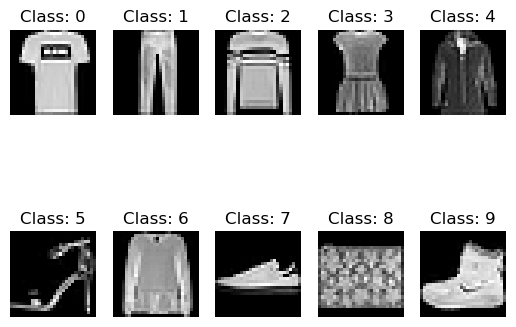

In [91]:
number_of_classes = len(np.unique(y_train_full))
for i in range(number_of_classes):
    plt.subplot(2, number_of_classes//2, i+1)
    #get records of class i
    images = X_train_full[y_train_full == i]
    #get one of images
    img = images[0]
    plt.imshow(img, cmap='gray')
    plt.title("Class: " + str(i))
    plt.axis('off')
plt.show()

Based on these images, we can label the classes as follows:

In [92]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Let us now look at the category of the first record in the training set:

In [93]:
class_names[y_train_full[0]]

'Ankle boot'

Let us now display the image of this record:

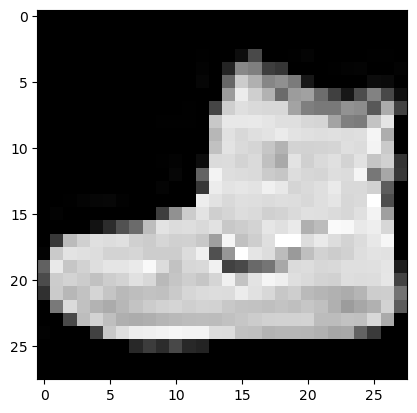

In [94]:
plt.imshow(X_train_full[0], cmap="gray")
plt.show()

We see that the label corresponds to the image. 

Let us split the training set into a train set and a validation set. We will also divide the values of the pixels by 255 as a form of standardization. However, before we do that, let us reshape the train and test data to include the number of channels. Since the images are grayscale images, there is only one channel per image:

In [95]:
X_train_full = X_train_full.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

We now scale the data and split the full training set into a train and valid test:

In [96]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# also scale the test set
X_test = X_test / 255.0

X_train.shape

(55000, 28, 28, 1)

We will now train a fully connected model to see how it performs, and then we will train a convoluted network in order to be able to compare it with the fully connected model.

We are going to perform batch normalization before the activation function, so we will specify each separately. We will aos use drop out as a regularization technique:

In [97]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Dense(300),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(100),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5468 - accuracy: 0.8055 - val_loss: 0.3838 - val_accuracy: 0.8640
Epoch 2/20
1719/1719 [==============================] - 15s 8ms/step - loss: 0.4224 - accuracy: 0.8489 - val_loss: 0.3602 - val_accuracy: 0.8674
Epoch 3/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3873 - accuracy: 0.8591 - val_loss: 0.3418 - val_accuracy: 0.8760
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3614 - accuracy: 0.8689 - val_loss: 0.3189 - val_accuracy: 0.8842
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3415 - accuracy: 0.8750 - val_loss: 0.3159 - val_accuracy: 0.8800
Epoch 6/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3287 - accuracy: 0.8787 - val_loss: 0.3256 - val_accuracy: 0.8792
Epoch 7/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3152 - accuracy: 0.8828 - val_loss: 0.3277 - val_accurac

We see that the accuracy on the validation set is around 89%, which is not bad for a model that was trained so fast. Let us evaluate the model using the test data set:

In [98]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.2983 - accuracy: 0.8938


[0.29827064275741577, 0.8938000202178955]

The accuracy on the test data set is also around 89%.

When it comes to visual data, convolution networks tend to deliver the best results for various reasons. Unlike fully connected networks, where every input is connected to all the nodes and each node in each layer is connected to the noed of the next layer, CNN take a different appraoch, where instead of simply considering al lpossible connections, the network allows different nodes to focus on different parts of the image. The logic behind this is that different parts of the network will be able to extract different patterns. This is done by using filters. In these types of networks, the first layers are CNN layers, while the last few layers are fully connected layers. Let us take a look at one such example.

In the model below, we will use several 2D concolution layers where each is followed by batch notmalization and then an activation function (just like what we did in the fully connected network). We will also start with 32 filters, and increase the number as we gradually move deeper into the network. We will use max pooling to aggregate the results. This will cause the dimensions to decrease as we go deeper. In other words, as we move from layer to layer, the dimensions will get smaller but the depth will increase. This is usually how convolution networks are built. The increasing deapth should allow us to capture more complex patterns.

In [99]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'Same', input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'Same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'Same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'Same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(256),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(10, activation='softmax')
])

 Notice also that the input_shape parameter of the first layer is set to [28, 28, 1]. This is because, as we previously saw, the size of each image is 28 x 28. The 1 refers to the number of channels. Since the images we are working with a grayscale, they only have one channel.

Let us train this model now:

In [100]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 [==============================] - 673s 391ms/step - loss: 0.3451 - accuracy: 0.8753 - val_loss: 0.2210 - val_accuracy: 0.9194
Epoch 2/20
1719/1719 [==============================] - 673s 391ms/step - loss: 0.2341 - accuracy: 0.9135 - val_loss: 0.1997 - val_accuracy: 0.9250
Epoch 3/20
1719/1719 [==============================] - 636s 370ms/step - loss: 0.1936 - accuracy: 0.9288 - val_loss: 0.1918 - val_accuracy: 0.9246
Epoch 4/20
1719/1719 [==============================] - 675s 393ms/step - loss: 0.1655 - accuracy: 0.9385 - val_loss: 0.1761 - val_accuracy: 0.9366
Epoch 5/20
1719/1719 [==============================] - 644s 374ms/step - loss: 0.1361 - accuracy: 0.9498 - val_loss: 0.1807 - val_accuracy: 0.9322
Epoch 6/20
1719/1719 [==============================] - 652s 379ms/step - loss: 0.1163 - accuracy: 0.9571 - val_loss: 0.1735 - val_accuracy: 0.9396
Epoch 7/20
1719/1719 [==============================] - 696s 405ms/step - loss: 0.0944 - accuracy: 0.9644 - val_

With the CNN model, the validation accuracy increased from 89% to 93%. Let us now evaluate the model using the test set:

In [101]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.3494 - accuracy: 0.9282


[0.3493913412094116, 0.9282000064849854]

The test set accuracy is around 92%, which is better than what we got wit hthe fully connected model.

In both the fully connected model and the CNN model, we noticed that there was a drop in accuracy when going from the training set to the validation set and then when going to the test set. This is normal, but since the difference between the accuracy of the training set and the accuracy of the test set was somehow large, it might be the case that we are over fitting, hence the model is not generalizing well. 

One technique to improve model generelizability is to augment the data by creating random variants of the training set. We will basically creates new variants of the images by zooming a bit into the image, shifting the image either horizontally or vertically, and even slightly rotating the image. By training the model on these augmented data points, the model should be able to generalize better. Let us do this and see if it makes a difference. We will use this technnique first with the fully connected model:

In [102]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    )

datagen.fit(X_train)
X_train_augmented = datagen.flow(X_train, y_train, batch_size=32)

The above code uses the ImageDataGenerator class to create an object that will allow is to apply random transformations to the images. We specify the parameters that were are interested in, such as rotating the image, zooming into the image, and shifting the image. This object is then fit on the train set and finally the augmented data set is created. This augmented data set will be used to train the model:

In [103]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Dense(300),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(100),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_augmented, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 [==============================] - 20s 11ms/step - loss: 0.8451 - accuracy: 0.6850 - val_loss: 0.5404 - val_accuracy: 0.8006
Epoch 2/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.7123 - accuracy: 0.7329 - val_loss: 0.5592 - val_accuracy: 0.7718
Epoch 3/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.6663 - accuracy: 0.7485 - val_loss: 0.4655 - val_accuracy: 0.8276
Epoch 4/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.6393 - accuracy: 0.7603 - val_loss: 0.4553 - val_accuracy: 0.8268
Epoch 5/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.6245 - accuracy: 0.7639 - val_loss: 0.4365 - val_accuracy: 0.8360
Epoch 6/20
1719/1719 [==============================] - 20s 12ms/step - loss: 0.6064 - accuracy: 0.7718 - val_loss: 0.4190 - val_accuracy: 0.8460
Epoch 7/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.5982 - accuracy: 0.7746 - val_loss: 0.4028 -

The accuracy of the model on the validation set (87%) is lower than on the original data set (89%). Let us see how well the model does on the test set:

In [104]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3887 - accuracy: 0.8602


[0.3886522948741913, 0.8601999878883362]

There is a three percentage points drop in the test accuracy between the fully connected model with no data augmentation and the fully connected model with data augmentation (from 89% to 86%). It seems that data ugmentation was not beneficial for the fully connected network. Let us now use the augmented data set to train the CNN:

In [105]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'Same', input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'Same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'Same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'Same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(256),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_augmented, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 [==============================] - 531s 309ms/step - loss: 0.5203 - accuracy: 0.8090 - val_loss: 0.3638 - val_accuracy: 0.8620
Epoch 2/20
1719/1719 [==============================] - 570s 331ms/step - loss: 0.3776 - accuracy: 0.8608 - val_loss: 0.3033 - val_accuracy: 0.8888
Epoch 3/20
1719/1719 [==============================] - 593s 345ms/step - loss: 0.3347 - accuracy: 0.8758 - val_loss: 0.2814 - val_accuracy: 0.8924
Epoch 4/20
1719/1719 [==============================] - 562s 327ms/step - loss: 0.3079 - accuracy: 0.8857 - val_loss: 0.2600 - val_accuracy: 0.9010
Epoch 5/20
1719/1719 [==============================] - 461s 268ms/step - loss: 0.2916 - accuracy: 0.8936 - val_loss: 0.2322 - val_accuracy: 0.9140
Epoch 6/20
1719/1719 [==============================] - 450s 262ms/step - loss: 0.2756 - accuracy: 0.8994 - val_loss: 0.2763 - val_accuracy: 0.8930
Epoch 7/20
1719/1719 [==============================] - 485s 282ms/step - loss: 0.2658 - accuracy: 0.9037 - val_

The validation set accuracy is 93%, which is the same as what we got with no dat aaugmentation. Let us now look at the test set accuracyL

In [106]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.2095 - accuracy: 0.9311


[0.20954646170139313, 0.9311000108718872]

There is a small increase from 92% to 93% when we use data augmentation. 

In general data augmentation can benefit both fully connected networks and CNNs. However, in our case, it was not beneficial to fully connected networks. This can happen sometimes. Fully connected networks are designed to learn global features, while CNNs are designed to learn spatial features that might be present anywhere in an image. As such, data augmentation increases the generalizability of CNNs by increasing the diversity and complexity of the spatial features that these networks learn.